<a href="https://colab.research.google.com/github/GU-DPM/EvolutionaryClassifier/blob/main/analysis/Explore_DPM_Trial_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup

In [ ]:
# set up bq environment
from google.colab import auth
from google.colab import data_table
from google.cloud import bigquery
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [ ]:
# setup project info - email matthew.mccoy@georgetown.edu about access
from google.colab import drive
drive.mount('/content/drive')

project = 'mccoylab' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)

Mounted at /content/drive


In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 11.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=b70c71224c91e8bcdfac8ff37c2c001798b36e5a823235031893344c81f84da8
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


## functions used in analysis

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

# Assuming client is a global variable
def retrieve_study_population(output_file_path):
    """
    Executes a SQL query and saves the resulting dataframe to a CSV file.
    If the file already exists, loads the dataframe from the file and returns it.

    Parameters:
    output_file_path (str): The path where the output CSV file will be saved.

    Returns:
    pd.DataFrame: The resulting dataframe.
    """
    # Check if the output file already exists
    if os.path.exists(output_file_path):
        print(f"File {output_file_path} already exists. Loading dataframe from file.")
        return pd.read_csv(output_file_path)

    # Base query
    query = '''
    SELECT ec.Parameter_ID, ec.Survival_CPM, ec.Survival_DPM, ec.Survival_DPMtrial, ec.EC_category,
           sp.S_pop, sp.R1_pop, sp.R2_pop, sp.R12_pop, sp.g0,
           sp.S_cell_sensitivity_D1, sp.S_cell_sensitivity_D2,
           sp.R1_cell_sensitivity_D1, sp.R1_cell_sensitivity_D2,
           sp.R2_cell_sensitivity_D1, sp.R2_cell_sensitivity_D2,
           sp.R12_cell_sensitivity_D1, sp.R12_cell_sensitivity_D2,
           sp.S_transition_to_R1, sp.S_transition_to_R2,
           sp.R1_transition_to_R12, sp.R2_transition_to_R12
    FROM mccoylab.DPM_EC.ECsurvival_CPM_under_4_years ec
    JOIN mccoylab.DPM_EC.simParamOutput sp
    ON ec.Parameter_ID = sp.Parameter_ID
    WHERE 1=1
      AND sp.S_cell_sensitivity_D1 > 0.2 * sp.g0
      AND sp.S_cell_sensitivity_D2 > 0.2 * sp.g0
      AND sp.R12_cell_sensitivity_D1 < sp.g0
      AND sp.R12_cell_sensitivity_D2 < sp.g0
    '''

    # Execute the query and convert the result to a dataframe
    dataframe = client.query(query).to_dataframe()

    # Save the dataframe to a CSV file
    dataframe.to_csv(output_file_path, index=False)
    print(f"Dataframe saved to {output_file_path}")

    return dataframe

def retrieve_individual_patient(parameter_id, output_dir):
    """
    Executes a SQL query and saves the resulting dataframe to a CSV file.
    If the file already exists, loads the dataframe from the file and returns it.

    Parameters:
    output_dir (str): The directory where the output CSV file will be saved.
    parameter_id (str): The Parameter_ID to filter the results.

    Returns:
    pd.DataFrame: The resulting dataframe.
    """
    # Construct the output file path
    parameter_id = str(parameter_id)
    output_file_path = os.path.join(output_dir, f"{parameter_id}.trajectory.csv")

    # Check if the output file already exists
    if os.path.exists(output_file_path):
        print(f"File {output_file_path} already exists. Loading dataframe from file.")
        return pd.read_csv(output_file_path)

    # Query to get all results from simTrajectories that match Parameter_ID
    query = f'''
    SELECT *
    FROM mccoylab.DPM_EC.simTrajectories
    WHERE Parameter_ID = {parameter_id}
    '''
    print(query)
    # Execute the query and convert the result to a dataframe
    dataframe = client.query(query).to_dataframe()

    # Save the dataframe to a CSV file
    dataframe.to_csv(output_file_path, index=False)
    print(f"Dataframe saved to {output_file_path}")

    return dataframe

def add_benefit_columns(df, min_survival_days=60, min_percent_benefit=25):
    """
    Adds benefit columns to the dataframe based on survival days and percent benefit.

    Parameters:
    df (pd.DataFrame): The input dataframe.
    min_survival_days (int): Minimum survival days. Defaults to 60.
    min_percent_benefit (float): Minimum percent benefit. Defaults to 25.

    Returns:
    pd.DataFrame: The dataframe with added benefit columns.
    """
    # Calculate benefit_DPM
    df['benefit_DPM'] = (df['Survival_DPM'] - df['Survival_CPM'] >= min_survival_days) & \
                        ((df['Survival_DPM'] - df['Survival_CPM']) / df['Survival_CPM'] >= min_percent_benefit / 100)

    # Calculate benefit_DPMtrial
    df['benefit_DPMtrial'] = (df['Survival_DPMtrial'] - df['Survival_CPM'] >= min_survival_days) & \
                             ((df['Survival_DPMtrial'] - df['Survival_CPM']) / df['Survival_CPM'] >= min_percent_benefit / 100)

    # Calculate Extraordinary_Benefit
    df['Extraordinary_Benefit'] = df['benefit_DPMtrial'] & \
                                  (df['Survival_DPM'] - df['Survival_DPMtrial'] >= min_survival_days) & \
                                  ((df['Survival_DPM'] - df['Survival_DPMtrial']) / df['Survival_DPMtrial'] >= min_percent_benefit / 100)

    return df

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
# plot EC and calc HZ for subset population
def plot_km(df, population_id=None, file_path=None):
    # Check if the file path is provided and if the file already exists
    if file_path and os.path.exists(file_path):
        print(f"The plot already exists at {file_path}. Displaying the plot.")
        img = plt.imread(file_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
        return

    kmf = KaplanMeierFitter()
    # Plot survival curves for each Survival column for the subset
    plt.figure(figsize=(10, 6))

    # Define a mapping from old labels to new labels
    label_mapping = {
        'Survival_CPM': 'CPM',
        'Survival_DPM': '40-move DPM',
        'Survival_DPMtrial': '2-move DPM'
    }

    for column in ['Survival_CPM', 'Survival_DPM', 'Survival_DPMtrial']:
        kmf.fit(df[column], event_observed=[1]*len(df))  # Adjust event_observed if needed
        kmf.plot_survival_function(label=label_mapping[column])

    plt.title(f'Survival Curves for {population_id} (n={len(df)})', fontsize=20)
    plt.xlabel('Days', fontsize=16)
    plt.ylabel('Survival Probability', fontsize=16)
    plt.legend(fontsize=18)

    # Save the plot to the specified file path if provided, otherwise just show the plot
    if file_path:
        plt.savefig(file_path)
        print(f"The plot has been saved to {file_path}.")
    else:
        plt.show()

def calc_hazard_ratio(df, population_id=None, file_path=None):
    # Check if the file path is provided and if the file already exists
    if file_path and os.path.exists(file_path):
        print(f"The file already exists at {file_path}. Loading and printing the content.")
        with open(file_path, 'r') as f:
            print(f.read())
        return

    # Prepare the data for PHReg to compare Survival_CPM and Survival_DPM
    df_long_cpm_dpm = pd.melt(df, id_vars=['Parameter_ID'], value_vars=['Survival_CPM', 'Survival_DPM'],
                              var_name='Survival_Type', value_name='Days')

    # Add an event column (assuming all events are observed)
    df_long_cpm_dpm['Event'] = 1

    # Convert categorical variable to dummy/indicator variables
    df_long_cpm_dpm = pd.get_dummies(df_long_cpm_dpm, columns=['Survival_Type'], drop_first=True)

    # Fit the Cox Proportional Hazards model
    cph_cpm_dpm = CoxPHFitter()
    cph_cpm_dpm.fit(df_long_cpm_dpm, duration_col='Days', event_col='Event', formula='Survival_Type_Survival_DPM')

    output = []

    if population_id:
        output.append(f"Hazard Ratio between Survival_CPM and Survival_DPM for {population_id}:")
    else:
        output.append("Hazard Ratio between Survival_CPM and Survival_DPM:")
    output.append(str(cph_cpm_dpm.summary))

    # Prepare the data for PHReg to compare Survival_CPM and Survival_DPMtrial
    df_long_cpm_dpmtrial = pd.melt(df, id_vars=['Parameter_ID'], value_vars=['Survival_CPM', 'Survival_DPMtrial'],
                                   var_name='Survival_Type', value_name='Days')

    # Add an event column (assuming all events are observed)
    df_long_cpm_dpmtrial['Event'] = 1

    # Convert categorical variable to dummy/indicator variables
    df_long_cpm_dpmtrial = pd.get_dummies(df_long_cpm_dpmtrial, columns=['Survival_Type'], drop_first=True)

    # Fit the Cox Proportional Hazards model
    cph_cpm_dpmtrial = CoxPHFitter()
    cph_cpm_dpmtrial.fit(df_long_cpm_dpmtrial, duration_col='Days', event_col='Event', formula='Survival_Type_Survival_DPMtrial')

    if population_id:
        output.append(f"\nHazard Ratio between Survival_CPM and Survival_DPMtrial for {population_id}:")
    else:
        output.append("\nHazard Ratio between Survival_CPM and Survival_DPMtrial:")
    output.append(str(cph_cpm_dpmtrial.summary))

    # Print the output to the screen
    print('\n'.join(output))

    if file_path:
        with open(file_path, 'w') as f:
            f.write('\n'.join(output))
        print(f"The output has been saved to {file_path}.")
    print('break')
    print(cph_cpm_dpm.summary)
    # Create a DataFrame with the hazard ratios and population_id
    hr_data = {
        'Comparison': ['Survival_CPM vs Survival_DPM', 'Survival_CPM vs Survival_DPMtrial'],
        'Hazard_Ratio': [cph_cpm_dpm.hazard_ratios_['Survival_Type_Survival_DPM'], cph_cpm_dpmtrial.hazard_ratios_['Survival_Type_Survival_DPMtrial']],
        'Population_ID': [population_id, population_id]
    }

    hr_df = pd.DataFrame(hr_data)

    return hr_df

def calculate_confusion_matrix(study_population, excluded_population, mode='trial'):
    if mode == 'full':
        benefit_col = 'benefit_DPM'
    elif mode == 'trial':
        benefit_col = 'benefit_DPMtrial'
    else:
        raise ValueError("Mode must be either 'full' or 'trial'")

    tp = sum(study_population[benefit_col])
    fp = len(study_population) - tp
    tn = sum(~excluded_population[benefit_col])
    fn = len(excluded_population) - tn

    return tp, fp, tn, fn

import math

def calculate_odds_ratio_and_ci(a, b, c, d):
    # Calculate the odds ratio
    #odds_ratio = (a * d) / (b * c)
    odds_ratio = (a * c) / (b * d)
    # Calculate the natural logarithm of the odds ratio
    ln_or = math.log(odds_ratio)

    # Calculate the standard error of the ln(OR)
    se_ln_or = math.sqrt((1/a) + (1/b) + (1/c) + (1/d))

    # Calculate the 95% confidence interval
    lower_ci = math.exp(ln_or - 1.96 * se_ln_or)
    upper_ci = math.exp(ln_or + 1.96 * se_ln_or)

    return odds_ratio, lower_ci, upper_ci

# Function to calculate odds ratio with confidence intervals and other metrics
def calculate_metrics(tp, fp, tn, fn):
    # Odds ratio and confidence intervals using Fisher's exact test
    odds_ratio, lower_ci, upper_ci = calculate_odds_ratio_and_ci(tp, fp, tn, fn)

    # Accuracy
    accuracy = (tp + tn) / (tp + fp + tn + fn)

    # Positive Predictive Value (PPV) or Precision
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Negative Predictive Value (NPV)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Sensitivity or Recall
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # F1 Score
    f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0

    return {
        "odds_ratio": odds_ratio,
        "lower_ci": lower_ci,
        "upper_ci": upper_ci,
        "accuracy": accuracy,
        "ppv": ppv,
        "npv": npv,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "f1_score": f1_score,
        "tp": tp,
        "fp": fp,
        "tn": tn,
        "fn": fn
    }

def get_classifier_metrics_trialDPM(study_population, excluded_population, population_id):
    tp, fp, tn, fn = calculate_confusion_matrix(study_population, excluded_population)
    #print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    metrics = calculate_metrics(tp, fp, tn, fn)
    #print(metrics)
    metrics["population_id"] = population_id
    metrics_df = pd.DataFrame(metrics, index = [0])
    #print(metrics_df)
    return metrics_df

def get_classifier_metrics(study_population, excluded_population, population_id, mode='trial'):
    tp, fp, tn, fn = calculate_confusion_matrix(study_population, excluded_population, mode)
    #print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    metrics = calculate_metrics(tp, fp, tn, fn)
    #print(metrics)
    metrics["population_id"] = population_id
    metrics_df = pd.DataFrame(metrics, index=[0])
    #print(metrics_df)
    return metrics_df

import seaborn as sns
import matplotlib.pyplot as plt

def plot_patient_trajectories(df):
    # Set the style of the visualization
    sns.set(style="whitegrid")

    # Create a figure and axis for each Strategy_name
    figs = []
    for strategy in df['Strategy_name'].unique():
        fig = plt.figure(figsize=(10, 12))
        figs.append(fig)

        strategy_df = df[df['Strategy_name'] == strategy]

        # Plot populations
        ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6])  # [left, bottom, width, height]
        for pop in ['Spop', 'R1pop', 'R2pop', 'R12pop']:
            sns.lineplot(data=strategy_df, x='timepoint', y=pop, ax=ax1, label=pop)

        ax1.set_yscale('log')  # Set y-axis to exponential scale
        ax1.set_ylim(bottom=10e-3)  # Set the lower limit of the y-axis to 10e-3
        ax1.axhline(y=10**9, color='gray', linestyle='--')  # Add horizontal dotted line at 10^9
        ax1.axhline(y=10**12, color='gray', linestyle='--')  # Add horizontal dotted line at 10^12
        ax1.set_title(f'Strategy: {strategy}')
        ax1.set_ylabel('Population')
        ax1.legend(loc='upper left')

        # Plot Drug1_dosage
        ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.15])  # [left, bottom, width, height]
        sns.lineplot(data=strategy_df, x='timepoint', y='Drug1_dosage', ax=ax2, color='black', linestyle='--', label='Drug1_dosage')
        ax2.set_ylabel('Drug1 Dosage')
        ax2.set_xlabel('Timepoint')
        ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

## analysis

In [ ]:
len(['Parameter_ID', 'Survival_CPM', 'Survival_DPM', 'Survival_DPMtrial','EC_category', 'S_pop', 'R1_pop', 'R2_pop', 'R12_pop', 'g0','S_cell_sensitivity_D1', 'S_cell_sensitivity_D2','R1_cell_sensitivity_D1', 'R1_cell_sensitivity_D2','R2_cell_sensitivity_D1', 'R2_cell_sensitivity_D2','R12_cell_sensitivity_D1', 'R12_cell_sensitivity_D2',
       'S_transition_to_R1', 'S_transition_to_R2', 'R1_transition_to_R12','R2_transition_to_R12', ])

22

In [ ]:
# retrieve the base study population. 1 small difference from the manuscript is the additional exclusion of patients with survival < 45 days
sim_data_dir = '/content/drive/MyDrive/dpmTrialResults/output_mapping_Oct24/simulation_data'
analyis_dir = '/content/drive/MyDrive/dpmTrialResults/output_mapping_Oct24/exploration/publication_figs'
pop_survival_and_param_file = 'EC_survival_and_params.csv'

#population_df = retrieve_study_population(os.path.join(sim_data_dir,pop_survival_and_param_file))
population_df = add_benefit_columns(population_df)
population_df.columns

Index(['Parameter_ID', 'Survival_CPM', 'Survival_DPM', 'Survival_DPMtrial',
       'EC_category', 'S_pop', 'R1_pop', 'R2_pop', 'R12_pop', 'g0',
       'S_cell_sensitivity_D1', 'S_cell_sensitivity_D2',
       'R1_cell_sensitivity_D1', 'R1_cell_sensitivity_D2',
       'R2_cell_sensitivity_D1', 'R2_cell_sensitivity_D2',
       'R12_cell_sensitivity_D1', 'R12_cell_sensitivity_D2',
       'S_transition_to_R1', 'S_transition_to_R2', 'R1_transition_to_R12',
       'R2_transition_to_R12', 'benefit_DPM', 'benefit_DPMtrial',
       'Extraordinary_Benefit'],
      dtype='object')

### analyze subpopulations

In [ ]:
# Select subpopulations by EC class
ec_pop_sets = {"Whole Population" : None,
                "Whole Population With DPM Trial Change": ["both_diff", "first_same_only", "second_same_only"],
            "Both Moves Same" : ["both_same"],
            "Both Diff" : ["both_diff"],
            "First Same Only" : ["first_same_only"],
            "Second Same Only" : ["second_same_only"],
            "EC1" : ['second_same_only', 'both_diff'],
            "Not EC1": ['first_same_only', 'both_same'],
}

# keys are the subpopulation name, value is list of EC categories to include
subpop_name = "EC1"
subpop_ec_categories = ec_pop_sets[subpop_name]
# or
# subpop_ec_categories = ['second_same_only', 'both_diff']

analysis_population = population_df[population_df['EC_category'].isin(subpop_ec_categories)]
excluded_population = population_df[~population_df['EC_category'].isin(subpop_ec_categories)]

# subset by benefit and/or survivial
#
#

The plot already exists at /content/drive/MyDrive/dpmTrialResults/output_mapping_Oct24/exploration/EC1_km.png. Displaying the plot.


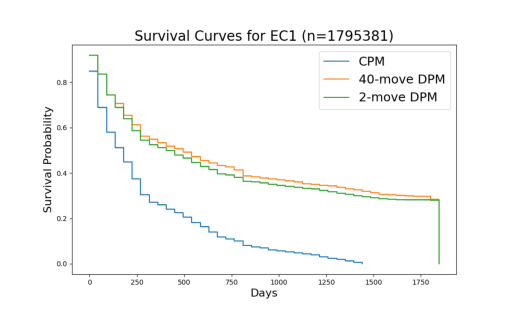

In [ ]:
# plot km for subpopulation
plot_km(analysis_population, population_id=subpop_name, file_path=os.path.join(analyis_dir, f'{subpop_name}_km.png'))



In [ ]:
# calculate hazard ratios for subpopulation
# can take a while for large populations, but will load and display previous results saved as txt file on second running.
calc_hazard_ratio(analysis_population, population_id=subpop_name, file_path=os.path.join(analyis_dir, f'{subpop_name}_hr.txt'))

The file already exists at /content/drive/MyDrive/dpmTrialResults/output_mapping_Oct24/exploration/EC1_hr.txt. Loading and printing the content.
Hazard Ratio between Survival_CPM and Survival_DPM for EC1:
                                coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                   
Survival_Type_Survival_DPM -0.992093     0.3708  0.001232       -0.994507   

                            coef upper 95%  exp(coef) lower 95%  \
covariate                                                         
Survival_Type_Survival_DPM       -0.989678             0.369906   

                            exp(coef) upper 95%  cmp to           z    p  \
covariate                                                                  
Survival_Type_Survival_DPM             0.371696     0.0 -805.374343  0.0   

                            -log2(p)  
covariate                             
Survival_Type_Survival_DPM       inf  

Hazard Ratio b

In [ ]:
# classifier metrics if subpopulation was used to predict benefit from trial
get_classifier_metrics(analysis_population, excluded_population, subpop_name)

,odds_ratio,lower_ci,upper_ci,accuracy,ppv,npv,sensitivity,specificity,f1_score,tp,fp,tn,fn,population_id
0,20.772126,20.541124,21.005726,0.616782,0.360877,0.973537,0.950027,0.522135,0.523064,647912,1147469,1253771,34081,EC1


In [ ]:
# classifier metrics if subpopulation was used to predict benefit from full DPM
get_classifier_metrics(analysis_population, excluded_population, subpop_name, mode='full')

,odds_ratio,lower_ci,upper_ci,accuracy,ppv,npv,sensitivity,specificity,f1_score,tp,fp,tn,fn,population_id
0,5.724028,5.689125,5.759145,0.620793,0.433313,0.882157,0.836765,0.527552,0.570959,777962,1017419,1136088,151764,EC1


### analyze individual patients

In [ ]:
# look for an example patient

#population_df[population_df['Extraordinary_Benefit'] == True]
#population_df[population_df['S_pop'] > population_df['R1_pop']]

popfilter1 = population_df[population_df['Survival_CPM'] > 1000]
#popfilter2 = popfilter1[popfilter1['benefit_DPMtrial'] == True]
#popfilter2[popfilter2['S_pop'] > popfilter2['R1_pop']]

In [ ]:
popfilter1

,Parameter_ID,Survival_CPM,Survival_DPM,Survival_DPMtrial,EC_category,S_pop,R1_pop,R2_pop,R12_pop,g0,...,R2_cell_sensitivity_D2,R12_cell_sensitivity_D1,R12_cell_sensitivity_D2,S_transition_to_R1,S_transition_to_R2,R1_transition_to_R12,R2_transition_to_R12,benefit_DPM,benefit_DPMtrial,Extraordinary_Benefit
0,39157981,1350.0,1530.0,1530.0,both_diff,0.000000e+00,4.500000e+09,5.000000e+08,0.0,0.0184,...,8.428000e-06,0.000000e+00,8.428000e-06,1.000000e-07,4.642000e-09,4.642000e-09,1.000000e-07,False,False,False
1,25167750,1125.0,1260.0,1260.0,both_diff,4.995000e+09,5.000000e+06,5.000000e+02,0.0,0.0184,...,1.548500e-05,8.096000e-05,1.548500e-05,1.000000e-07,1.000000e-03,1.000000e-03,1.000000e-07,False,False,False
2,38341635,1350.0,1350.0,1350.0,both_same,4.950000e+08,4.500000e+09,5.000000e+06,0.0,0.0184,...,4.371800e-07,0.000000e+00,4.371800e-07,4.642000e-09,1.000000e-07,1.000000e-07,4.642000e-09,False,False,False
3,35871455,1170.0,1170.0,1170.0,both_same,5.000000e+08,4.500000e+09,5.000000e+00,0.0,0.0184,...,3.998500e-05,8.096000e-05,3.998500e-05,1.000000e-07,2.154000e-06,2.154000e-06,1.000000e-07,False,False,False
4,38195757,1395.0,1665.0,1395.0,both_same,4.950000e+08,4.500000e+09,5.000000e+06,0.0,0.0070,...,1.968000e-03,3.337800e-07,1.968000e-03,2.154000e-10,4.642000e-05,4.642000e-05,2.154000e-10,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875816,16914303,1350.0,1620.0,1350.0,both_same,5.000000e+08,5.000000e+02,4.500000e+09,0.0,0.0184,...,3.809300e-04,7.332400e-03,3.809300e-04,1.000000e-03,1.000000e-11,1.000000e-11,1.000000e-03,False,False,False
2875817,2089349,1350.0,1530.0,1350.0,first_same_only,5.000000e+09,0.000000e+00,5.000000e+02,0.0,0.0184,...,4.352500e-07,8.428000e-06,4.352500e-07,4.642000e-05,1.000000e-07,1.000000e-07,4.642000e-05,False,False,False
3074349,35978237,1125.0,1845.0,1845.0,first_same_only,5.000000e+08,4.500000e+09,5.000000e+00,0.0,0.0487,...,1.376000e-02,1.940700e-02,1.376000e-02,4.642000e-05,2.154000e-10,2.154000e-10,4.642000e-05,True,True,False
3080705,37625309,1035.0,1845.0,1845.0,first_same_only,4.999500e+08,4.500000e+09,5.000000e+04,0.0,0.0487,...,1.376000e-02,1.940700e-02,1.376000e-02,1.000000e-07,2.154000e-10,2.154000e-10,1.000000e-07,True,True,False


File /content/drive/MyDrive/dpmTrialResults/output_mapping_Oct24/exploration/35978237.trajectory.csv already exists. Loading dataframe from file.


<ipython-input-4-866255a08a95>:353: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


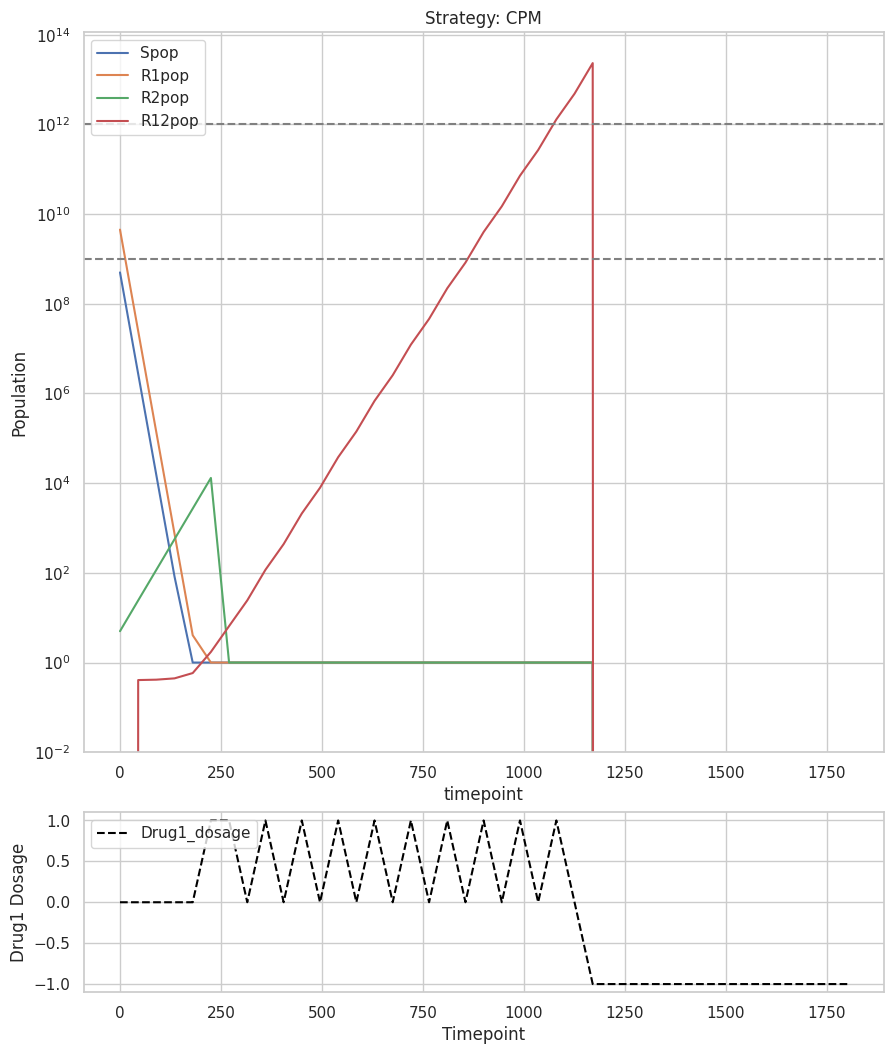

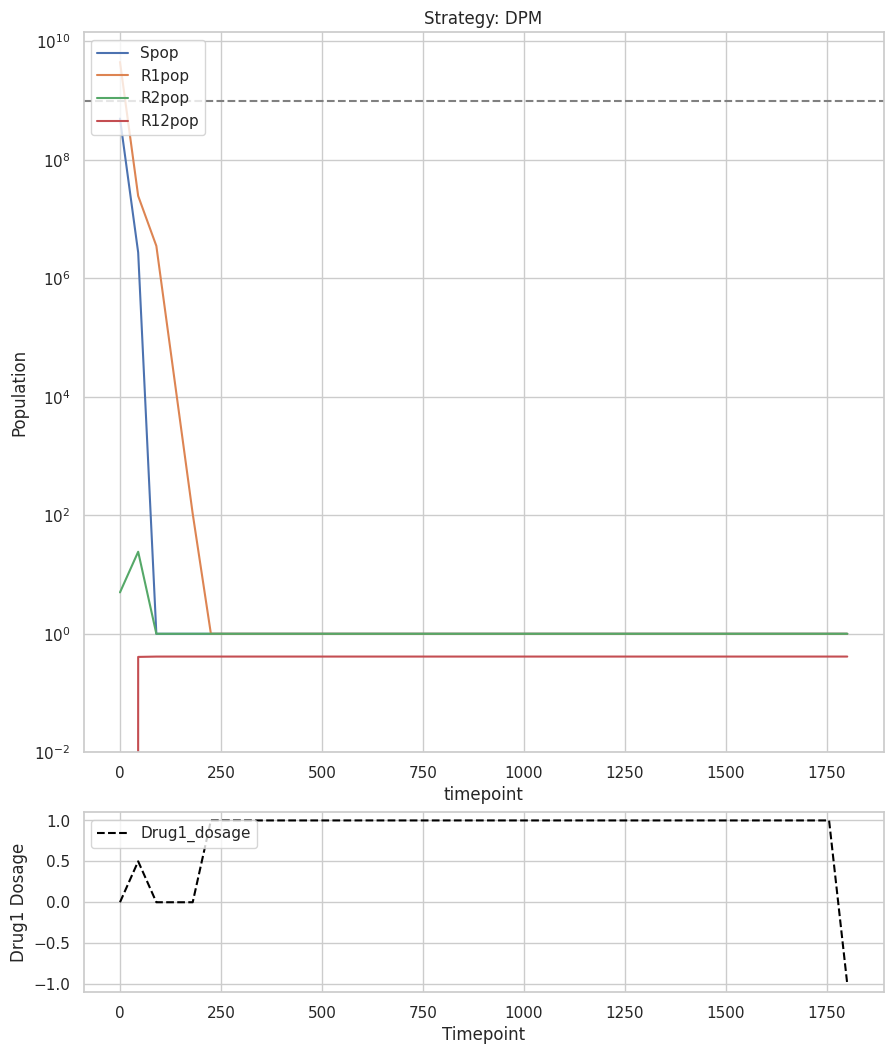

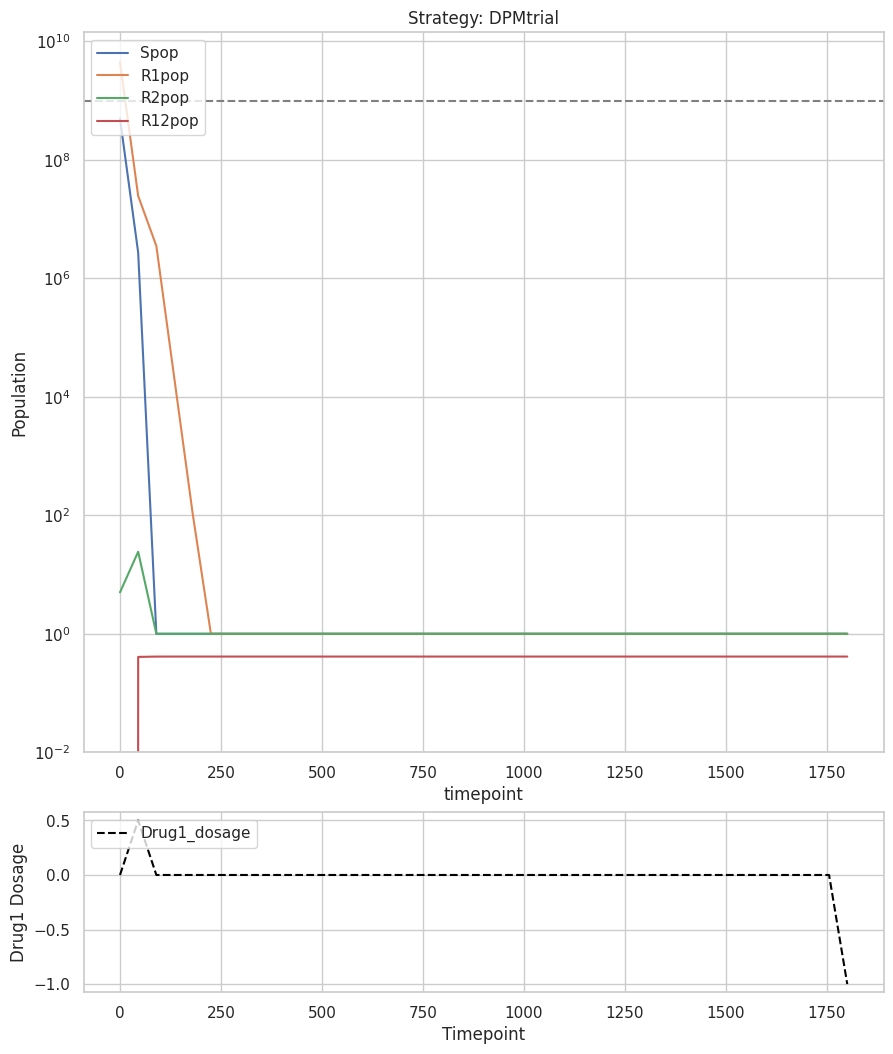

In [ ]:
# get patient trajectory
parameter_id = 35978237

patient_trajectory_df = retrieve_individual_patient(parameter_id, analyis_dir)
#patient_trajectory_df
plot_patient_trajectories(patient_trajectory_df)